In [1]:
import os
import cv2
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from PIL import Image, ImageTk
import yaml

class MotionEnergyApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Motion Energy ROI Tool")
        self.master.geometry("1000x700")
        
        self.video_files = []
        self.current_frame = None  # This will hold the colored (RGB) frame for display.
        self.current_video_index = 0
        self.cap = None
        # For each video file, store a dictionary with keys "ROI1", "ROI2", and "stim"
        self.rois = {}  
        self.dark_frame_indices = {}  # Store dark frame indices per video
        self.motion_energies = {}
        self.current_roi_name = None  # Which ROI is being defined right now.
        
        # GUI Elements
        self.load_button = tk.Button(master, text="Load Directory", command=self.load_directory)
        self.load_button.pack()
        
        self.video_label = tk.Label(master, text="Video: None")
        self.video_label.pack()
        
        self.canvas_frame = tk.Frame(master)
        self.canvas_frame.pack(fill=tk.BOTH, expand=True)
        self.canvas = None
        
        # Create three separate buttons for the three ROIs:
        self.draw_roi1_button = tk.Button(master, text="Draw ROI 1", command=lambda: self.enable_polygon_selector("ROI1"))
        self.draw_roi1_button.pack()
        self.draw_roi2_button = tk.Button(master, text="Draw ROI 2", command=lambda: self.enable_polygon_selector("ROI2"))
        self.draw_roi2_button.pack()
        self.draw_stim_button = tk.Button(master, text="Draw stim ROI", command=lambda: self.enable_polygon_selector("stim"))
        self.draw_stim_button.pack()
        
        self.set_dark_frame_button = tk.Button(master, text="Set Dark Frame Index", command=self.set_dark_frame_index)
        self.set_dark_frame_button.pack()
        
        self.process_all_button = tk.Button(master, text="Process All Videos", command=self.process_all_videos)
        self.process_all_button.pack()
        
        self.progress_bar = ttk.Progressbar(master, orient=tk.HORIZONTAL, length=400, mode='determinate')
        self.progress_bar.pack()
        
        self.next_button = tk.Button(master, text="Next Video", command=self.next_video)
        self.next_button.pack()
    
    def load_directory(self):
        folder_path = filedialog.askdirectory(title="Select Master Directory")
        if not folder_path:
            return
        
        self.video_files = []
        # Recursively find MP4 files
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".mp4"):
                    self.video_files.append(os.path.join(root, file))
        
        if not self.video_files:
            messagebox.showerror("Error", "No MP4 files found in the directory!")
            return
        
        self.current_video_index = 0
        self.load_video()

    def load_video(self):
        if self.cap:
            self.cap.release()
            
        if self.current_video_index >= len(self.video_files):
            messagebox.showinfo("Info", "No more videos to process!")
            return
        
        video_path = self.video_files[self.current_video_index]
        self.cap = cv2.VideoCapture(video_path)
        total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        middle_frame_idx = total_frames // 2
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
        ret, frame = self.cap.read()
        
        if not ret or frame is None:
            messagebox.showerror("Error", f"Failed to load video: {video_path}")
            return
        
        # Convert BGR (OpenCV default) to RGB for display.
        self.current_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.video_label.config(text=f"Video: {os.path.basename(video_path)}")
        
        self.display_frame(self.current_frame)
    
    def display_frame(self, frame):
        # Close the previous figure if it exists
        if hasattr(self, 'fig') and self.fig is not None:
            plt.close(self.fig)

        if self.canvas:
            self.canvas.get_tk_widget().destroy()
        
        self.fig, self.ax = plt.subplots()
        # Display the colored frame (do not use a grayscale cmap)
        self.ax.imshow(frame)
        self.ax.axis("off")
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.canvas_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        self.canvas.draw()
    
    def enable_polygon_selector(self, roi_name):
        if self.current_frame is None:
            messagebox.showerror("Error", "No video loaded!")
            return
        self.current_roi_name = roi_name
        self.selector = PolygonSelector(
            self.ax,
            self.on_polygon_complete,
            useblit=True,  # For faster drawing performance
            props=dict(color='red', linestyle='-', linewidth=2, alpha=0.5)
        )
    
    def on_polygon_complete(self, verts):
        video_path = self.video_files[self.current_video_index]
        # Ensure we have a dictionary for this video
        if video_path not in self.rois:
            self.rois[video_path] = {}
        self.rois[video_path][self.current_roi_name] = np.array(verts, dtype=np.int32)
        messagebox.showinfo("Info", f"ROI {self.current_roi_name} saved!")
        # Disconnect the selector after drawing
        self.selector.disconnect_events()
        del self.selector

    def set_dark_frame_index(self):
        if self.current_frame is None:
            messagebox.showerror("Error", "No video loaded!")
            return
        self.dark_frame_window = tk.Toplevel(self.master)
        self.dark_frame_window.title("Set Dark Frame Index")
        
        self.dark_frame_canvas = tk.Label(self.dark_frame_window)
        self.dark_frame_canvas.pack()
        
        total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.dark_frame_slider = tk.Scale(self.dark_frame_window, from_=0, to=total_frames, orient=tk.HORIZONTAL, length=400, command=self.update_frame_preview)
        self.dark_frame_slider.pack()
        
        self.dark_frame_window.bind("<Left>", lambda event: self.dark_frame_slider.set(self.dark_frame_slider.get() - 1))
        self.dark_frame_window.bind("<Right>", lambda event: self.dark_frame_slider.set(self.dark_frame_slider.get() + 1))
        
        tk.Label(self.dark_frame_window, text="Start Frame Index").pack()
        self.start_entry = tk.Entry(self.dark_frame_window)
        self.start_entry.pack()
        tk.Label(self.dark_frame_window, text="End Frame Index").pack()
        self.end_entry = tk.Entry(self.dark_frame_window)
        self.end_entry.pack()
        
        tk.Button(self.dark_frame_window, text="Save", command=self.save_dark_frames).pack()

    def update_frame_preview(self, frame_number):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_number))
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            height, width = frame.shape[:2]
            aspect_ratio = width / height
            new_width = 256
            new_height = int(new_width / aspect_ratio)
            frame = cv2.resize(frame, (new_width, new_height))
            frame = Image.fromarray(frame)
            frame = ImageTk.PhotoImage(frame)
            self.dark_frame_canvas.config(image=frame)
            self.dark_frame_canvas.image = frame

    def save_dark_frames(self):
        video_path = self.video_files[self.current_video_index]
        try:
            start_idx = int(self.start_entry.get())
            end_idx = int(self.end_entry.get())
        except ValueError:
            messagebox.showerror("Error", "Please enter valid integers for start and end indices.")
            return
        self.dark_frame_indices[video_path] = (start_idx, end_idx)
        self.dark_frame_window.destroy()
        messagebox.showinfo("Info", "Dark frames saved!")

    def process_all_videos(self):
        if self.current_frame is None:
            messagebox.showerror("Error", "No video loaded!")
            return
        total_videos = len(self.video_files)
        self.progress_bar['value'] = 0
        step = 100 / total_videos
        
        for idx, video_path in enumerate(self.video_files):
            # Make sure that all three ROIs and dark frame indices are defined for the video.
            if (video_path in self.rois and 
                all(key in self.rois[video_path] for key in ["ROI1", "ROI2", "stim"]) and 
                video_path in self.dark_frame_indices):
                self.calculate_motion_energy(video_path)
            self.progress_bar['value'] += step
            self.master.update_idletasks()
        
        messagebox.showinfo("Info", "Processing complete!")

    def calculate_motion_energy(self, video_path):
        # Retrieve dark frame indices
        start_frame, end_frame = self.dark_frame_indices[video_path]
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        # Make sure all three ROIs have been defined for this video.
        if video_path not in self.rois or not all(key in self.rois[video_path] for key in ["ROI1", "ROI2", "stim"]):
            messagebox.showerror("Error", f"Not all ROIs defined for video {os.path.basename(video_path)}")
            cap.release()
            return
        
        roi1 = self.rois[video_path]["ROI1"]
        roi2 = self.rois[video_path]["ROI2"]
        stim_roi = self.rois[video_path]["stim"]
        
        ret, frame = cap.read()
        if not ret:
            cap.release()
            return
        frame_height, frame_width = frame.shape[:2]
        
        # Create binary masks for each ROI (masks are 2D)
        mask1 = np.zeros((frame_height, frame_width), dtype=np.uint8)
        mask2 = np.zeros((frame_height, frame_width), dtype=np.uint8)
        mask_stim = np.zeros((frame_height, frame_width), dtype=np.uint8)
        cv2.fillPoly(mask1, [roi1], 255)
        cv2.fillPoly(mask2, [roi2], 255)
        cv2.fillPoly(mask_stim, [stim_roi], 255)
        
        motion_energy_roi1 = []
        motion_energy_roi2 = []
        stim_values = []
        
        # For the two main ROIs, we calculate motion energy on the grayscale version.
        prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # For stim ROI, we take the green channel average.
        stim_val = cv2.mean(frame[:, :, 1], mask=mask_stim)[0]
        stim_values.append(stim_val)
        
        # Process frames from start_frame+1 to end_frame.
        for i in range(start_frame + 1, end_frame):
            ret, frame = cap.read()
            if not ret:
                break
            # For ROI1 and ROI2, use grayscale.
            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # ROI1 motion energy (frame-to-frame difference)
            roi1_current = current_gray[mask1 == 255]
            roi1_prev = prev_gray[mask1 == 255]
            energy1 = np.abs(roi1_current - roi1_prev).mean()
            motion_energy_roi1.append(energy1)
            # ROI2 motion energy
            roi2_current = current_gray[mask2 == 255]
            roi2_prev = prev_gray[mask2 == 255]
            energy2 = np.abs(roi2_current - roi2_prev).mean()
            motion_energy_roi2.append(energy2)
            # For stim ROI, average the green channel (no frame-to-frame change)
            current_green = frame[:, :, 1]
            stim_val = cv2.mean(current_green, mask=mask_stim)[0]
            stim_values.append(stim_val)
            prev_gray = current_gray
        
        # For stim ROI, drop the first element so that its length matches the motion energy signals.
        stim_values = stim_values[1:]
        
        # Combine the three signals into a single numpy array.
        # (Row 0: ROI1, Row 1: ROI2, Row 2: stim ROI)
        result = np.array([motion_energy_roi1, motion_energy_roi2, stim_values])
        np.save(os.path.join(os.path.dirname(video_path), "motion_energy.npy"), result)
        
        # Create output mask PNG that shows only the ROIs and adds text labels.
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        ret, frame = cap.read()
        if ret:
            # Create a blank mask image (same size as frame) in color.
            mask_img = np.zeros_like(frame)
            # Fill each ROI with white.
            cv2.fillPoly(mask_img, [roi1], (255, 255, 255))
            cv2.fillPoly(mask_img, [roi2], (255, 255, 255))
            cv2.fillPoly(mask_img, [stim_roi], (255, 255, 255))
            mask_single = mask_img[:, :, 0]
            masked_frame = cv2.bitwise_and(frame, frame, mask=mask_single)
            # A helper function to put a text label at the centroid of a polygon.
            def put_label(img, poly, label):
                M = cv2.moments(poly)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = poly[0]
                cv2.putText(img, label, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            put_label(masked_frame, roi1, "ROI_1")
            put_label(masked_frame, roi2, "ROI_2")
            put_label(masked_frame, stim_roi, "stim")
            
            mask_png_path = os.path.join(os.path.dirname(video_path), "masked_frame.png")
            cv2.imwrite(mask_png_path, masked_frame)
        
        # Update metadata with the ROI coordinates and dark frame indices.
        metadata_path, _ = os.path.split(os.path.dirname(video_path))
        metadata_file = os.path.join(metadata_path, "metadata.yml")
        new_data = {
            'session': {
                'behavior': {
                    'start_idx': start_frame,
                    'end_idx': end_frame,
                    'ROI1_polygon_coords': roi1.tolist(),
                    'ROI2_polygon_coords': roi2.tolist(),
                    'stim_polygon_coords': stim_roi.tolist()
                }
            }
        }
        
        # Load existing metadata if file exists, otherwise initialize an empty dictionary.
        if os.path.exists(metadata_file):
            with open(metadata_file, 'r') as file:
                metadata = yaml.safe_load(file) or {}
        else:
            metadata = {}
        metadata.setdefault('session', {}).setdefault('behavior', {})
        metadata['session']['behavior'].update(new_data['session']['behavior'])
        with open(metadata_file, 'w') as file:
            yaml.dump(metadata, file, default_flow_style=False)
        
        cap.release()
    
    def next_video(self):
        self.current_video_index += 1
        self.load_video()

if __name__ == "__main__":
    root = tk.Tk()
    app = MotionEnergyApp(root)
    root.mainloop()


NOTE: You MUST select all 3 ROIs for the program to work. Feel free to modify the code to fix that. I just copy pasted it from mine, so it is required to have all of them. The output would have 3 rows:
index 0: is the first ROI (ROI_1)
index 1: is the second ROI (ROI_2)
index 2: is the stim ROI

Good lick ;)

In [24]:
data = np.load('/mnt/team/RaymondLab/1_Kai/2_Pi_data/3_third_cohort/475165/stage2_475165_f1/Videos/motion_energy.npy')

In [25]:
data.shape

(3, 19563)

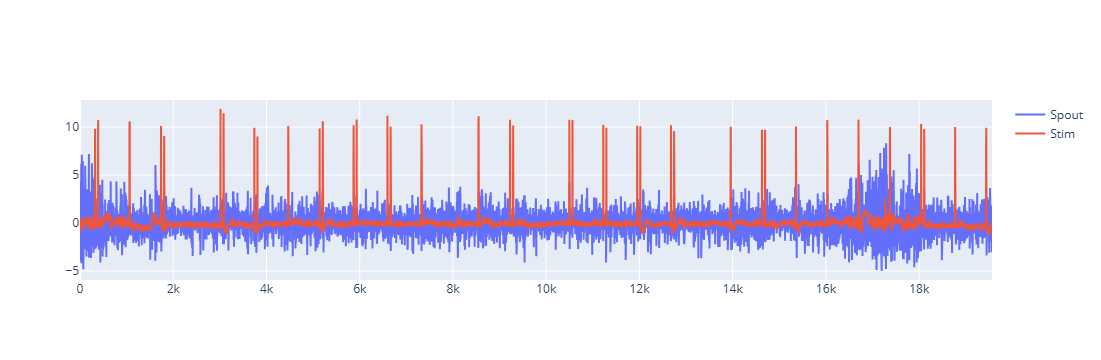

In [26]:
from scipy.stats import zscore
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=zscore(data[1,:]), mode='lines', name='Spout'))
fig.add_trace(go.Scatter(y=zscore(data[2,:]), mode='lines', name='Stim'))